##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Load video data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/video"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/video.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/video.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/video.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to load and preprocess [AVI](https://en.wikipedia.org/wiki/Audio_Video_Interleave) video data using the [UCF101 human action dataset](https://www.tensorflow.org/datasets/catalog/ucf101). Once you have preprocessed the data, it can be used for such tasks as video classification/recognition, captioning or clustering. The original dataset contains realistic action videos collected from YouTube with 101 categories, including playing cello, brushing teeth, and applying eye makeup. You will learn how to:

* Load the data from a zip file.

* Read sequences of frames out of the video files.

* Visualize the video data.

* Wrap the frame-generator [`tf.data.Dataset`](https://www.tensorflow.org/guide/data).

This video loading and preprocessing tutorial is the first part in a series of TensorFlow video tutorials. Here are the other three tutorials:

- [Build a 3D CNN model for video classification](https://www.tensorflow.org/tutorials/video/video_classification): Note that this tutorial uses a (2+1)D CNN that decomposes the spatial and temporal aspects of 3D data; if you are using volumetric data such as an MRI scan, consider using a 3D CNN instead of a (2+1)D CNN.
- [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): Get familiar with the MoViNet models that are available on TF Hub.
- [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): This tutorial explains how to use a pre-trained video classification model trained on a different dataset with the UCF-101 dataset.

## Setup

Begin by installing and importing some necessary libraries, including:
[remotezip](https://github.com/gtsystem/python-remotezip) to inspect the contents of a ZIP file, [tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files, and [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) for embedding data in a Jupyter notebook.

In [2]:
# The way this tutorial uses the `TimeDistributed` layer requires TF>=2.10
!pip install -U "tensorflow>=2.10.0"

In [3]:
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... -

 done


 done
  Created wheel for remotezip: filename=remotezip-0.11.1-py3-none-any.whl size=6700 sha256=b5ff3b9d792d734537fd937416bd2b9a6df148061288a7788bbc939a60f355ed
  Stored in directory: /home/kbuilder/.cache/pip/wheels/90/ef/51/16c5a5fcb74433fca65c15dbfaf866dedd7d7644d830b88933
Successfully built remotezip


In [4]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

2023-01-07 02:25:09.247388: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-07 02:25:09.247495: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-07 02:25:09.247505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Download a subset of the UCF101 dataset

The [UCF101 dataset](https://www.tensorflow.org/datasets/catalog/ucf101) contains 101 categories of different actions in video, primarily used in action recognition. You will use a subset of these categories in this demo.

In [5]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

The above URL contains a zip file with the UCF 101 dataset. Create a function that uses the `remotezip` library to examine the contents of the zip file in that URL:

In [6]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [7]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

Begin with a few videos and a limited number of classes for training. After running the above code block, notice that the class name is included in the filename of each video.

Define the `get_class` function that retrieves the class name from a filename. Then, create a function called `get_files_per_class` which converts the list of all files (`files` above) into a dictionary listing the files for each class:

In [8]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

In [9]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values). 
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

Once you have the list of files per class, you can choose how many classes you would like to use and how many videos you would like per class in order to create your dataset. 

In [10]:
NUM_CLASSES = 10
FILES_PER_CLASS = 50

In [11]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [12]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


Create a new function called `select_subset_of_classes` that selects a subset of the classes present within the dataset and a particular number of files per class:

In [13]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [14]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

Define helper functions that split the videos into training, validation, and test sets. The videos are downloaded from a URL with the zip file, and placed into their respective subdirectiories.

In [15]:
def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

The following function returns the remaining data that hasn't already been placed into a subset of data. It allows you to place that remaining data in the next specified subset of data.

In [16]:
def split_class_lists(files_for_class, count):
  """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

The following `download_ucf_101_subset` function allows you to download a subset of the UCF101 dataset and split it into the training, validation, and test sets. You can specify the number of classes that you would like to use. The `splits` argument allows you to pass in a dictionary in which the key values are the name of subset (example: "train") and the number of videos you would like to have per class.

In [17]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):
  """ Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [18]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 30, "val": 10, "test": 10},
                                       download_dir = download_dir)

train :


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:00<00:43,  6.83it/s]

  1%|          | 2/300 [00:00<00:47,  6.27it/s]

  1%|▏         | 4/300 [00:00<00:34,  8.53it/s]

  2%|▏         | 6/300 [00:00<00:27, 10.54it/s]

  3%|▎         | 8/300 [00:00<00:24, 11.79it/s]

  3%|▎         | 10/300 [00:01<00:30,  9.49it/s]

  4%|▍         | 12/300 [00:01<00:31,  9.18it/s]

  5%|▍         | 14/300 [00:01<00:27, 10.51it/s]

  5%|▌         | 16/300 [00:01<00:25, 11.29it/s]

  6%|▌         | 18/300 [00:01<00:23, 11.97it/s]

  7%|▋         | 20/300 [00:01<00:21, 12.84it/s]

  7%|▋         | 22/300 [00:01<00:20, 13.33it/s]

  8%|▊         | 24/300 [00:02<00:20, 13.41it/s]

  9%|▊         | 26/300 [00:02<00:19, 14.27it/s]

  9%|▉         | 28/300 [00:02<00:18, 14.39it/s]

 10%|█         | 30/300 [00:02<00:18, 14.25it/s]

 11%|█         | 32/300 [00:02<00:19, 13.53it/s]

 11%|█▏        | 34/300 [00:02<00:24, 10.80it/s]

 12%|█▏        | 36/300 [00:03<00:23, 11.47it/s]

 13%|█▎        | 38/300 [00:03<00:21, 12.13it/s]

 13%|█▎        | 40/300 [00:03<00:20, 12.62it/s]

 14%|█▍        | 42/300 [00:03<00:19, 13.40it/s]

 15%|█▍        | 44/300 [00:03<00:18, 13.62it/s]

 15%|█▌        | 46/300 [00:03<00:18, 13.86it/s]

 16%|█▌        | 48/300 [00:03<00:17, 14.48it/s]

 17%|█▋        | 50/300 [00:04<00:17, 14.42it/s]

 17%|█▋        | 52/300 [00:04<00:17, 14.42it/s]

 18%|█▊        | 54/300 [00:04<00:17, 14.36it/s]

 19%|█▊        | 56/300 [00:04<00:16, 14.46it/s]

 19%|█▉        | 58/300 [00:04<00:17, 14.07it/s]

 20%|██        | 60/300 [00:04<00:18, 13.12it/s]

 21%|██        | 62/300 [00:05<00:23,  9.92it/s]

 21%|██▏       | 64/300 [00:05<00:26,  9.02it/s]

 22%|██▏       | 66/300 [00:05<00:28,  8.08it/s]

 22%|██▏       | 67/300 [00:05<00:29,  7.84it/s]

 23%|██▎       | 69/300 [00:06<00:26,  8.58it/s]

 24%|██▎       | 71/300 [00:06<00:23,  9.68it/s]

 24%|██▍       | 73/300 [00:06<00:20, 10.95it/s]

 25%|██▌       | 75/300 [00:06<00:19, 11.77it/s]

 26%|██▌       | 77/300 [00:06<00:17, 12.63it/s]

 26%|██▋       | 79/300 [00:06<00:16, 13.33it/s]

 27%|██▋       | 81/300 [00:06<00:16, 13.46it/s]

 28%|██▊       | 83/300 [00:07<00:20, 10.48it/s]

 28%|██▊       | 85/300 [00:07<00:19, 11.19it/s]

 29%|██▉       | 87/300 [00:07<00:18, 11.24it/s]

 30%|██▉       | 89/300 [00:07<00:17, 12.00it/s]

 30%|███       | 91/300 [00:07<00:19, 10.85it/s]

 31%|███       | 93/300 [00:08<00:17, 11.74it/s]

 32%|███▏      | 95/300 [00:08<00:16, 12.38it/s]

 32%|███▏      | 97/300 [00:08<00:18, 10.74it/s]

 33%|███▎      | 99/300 [00:08<00:17, 11.51it/s]

 34%|███▎      | 101/300 [00:08<00:18, 10.86it/s]

 34%|███▍      | 103/300 [00:08<00:19, 10.02it/s]

 35%|███▌      | 105/300 [00:09<00:17, 11.07it/s]

 36%|███▌      | 107/300 [00:09<00:16, 12.01it/s]

 36%|███▋      | 109/300 [00:09<00:14, 12.84it/s]

 37%|███▋      | 111/300 [00:09<00:13, 13.66it/s]

 38%|███▊      | 113/300 [00:09<00:13, 14.26it/s]

 38%|███▊      | 115/300 [00:09<00:12, 14.40it/s]

 39%|███▉      | 117/300 [00:09<00:13, 13.76it/s]

 40%|███▉      | 119/300 [00:10<00:13, 13.45it/s]

 40%|████      | 121/300 [00:10<00:16, 10.74it/s]

 41%|████      | 123/300 [00:10<00:15, 11.60it/s]

 42%|████▏     | 125/300 [00:10<00:19,  9.13it/s]

 42%|████▏     | 127/300 [00:10<00:16, 10.68it/s]

 43%|████▎     | 129/300 [00:11<00:16, 10.06it/s]

 44%|████▎     | 131/300 [00:11<00:15, 11.17it/s]

 44%|████▍     | 133/300 [00:11<00:13, 12.18it/s]

 45%|████▌     | 135/300 [00:11<00:13, 12.36it/s]

 46%|████▌     | 137/300 [00:11<00:12, 12.55it/s]

 46%|████▋     | 139/300 [00:11<00:11, 13.71it/s]

 47%|████▋     | 141/300 [00:11<00:10, 14.47it/s]

 48%|████▊     | 143/300 [00:12<00:11, 14.13it/s]

 48%|████▊     | 145/300 [00:12<00:10, 14.31it/s]

 49%|████▉     | 147/300 [00:12<00:10, 14.80it/s]

 50%|████▉     | 149/300 [00:12<00:10, 14.62it/s]

 50%|█████     | 151/300 [00:12<00:11, 12.90it/s]

 51%|█████     | 153/300 [00:12<00:13, 10.82it/s]

 52%|█████▏    | 155/300 [00:13<00:13, 10.98it/s]

 52%|█████▏    | 157/300 [00:13<00:15,  9.44it/s]

 53%|█████▎    | 159/300 [00:13<00:13, 10.16it/s]

 54%|█████▎    | 161/300 [00:13<00:16,  8.29it/s]

 54%|█████▍    | 163/300 [00:14<00:15,  9.10it/s]

 55%|█████▌    | 165/300 [00:14<00:15,  8.77it/s]

 55%|█████▌    | 166/300 [00:14<00:17,  7.81it/s]

 56%|█████▌    | 168/300 [00:14<00:16,  8.18it/s]

 57%|█████▋    | 170/300 [00:14<00:14,  8.84it/s]

 57%|█████▋    | 171/300 [00:15<00:16,  7.76it/s]

 58%|█████▊    | 173/300 [00:15<00:14,  8.51it/s]

 58%|█████▊    | 175/300 [00:15<00:12,  9.95it/s]

 59%|█████▉    | 177/300 [00:15<00:11, 11.05it/s]

 60%|█████▉    | 179/300 [00:15<00:09, 12.19it/s]

 60%|██████    | 181/300 [00:15<00:09, 12.86it/s]

 61%|██████    | 183/300 [00:16<00:12,  9.29it/s]

 62%|██████▏   | 185/300 [00:16<00:13,  8.81it/s]

 62%|██████▏   | 187/300 [00:16<00:11,  9.78it/s]

 63%|██████▎   | 189/300 [00:16<00:10, 11.07it/s]

 64%|██████▎   | 191/300 [00:16<00:08, 12.26it/s]

 64%|██████▍   | 193/300 [00:17<00:08, 12.95it/s]

 65%|██████▌   | 195/300 [00:17<00:07, 13.58it/s]

 66%|██████▌   | 197/300 [00:17<00:07, 13.02it/s]

 66%|██████▋   | 199/300 [00:17<00:07, 14.16it/s]

 67%|██████▋   | 201/300 [00:17<00:07, 14.10it/s]

 68%|██████▊   | 203/300 [00:17<00:07, 13.27it/s]

 68%|██████▊   | 205/300 [00:17<00:06, 14.32it/s]

 69%|██████▉   | 207/300 [00:17<00:06, 14.58it/s]

 70%|██████▉   | 209/300 [00:18<00:06, 14.82it/s]

 70%|███████   | 211/300 [00:18<00:05, 14.93it/s]

 71%|███████   | 213/300 [00:18<00:05, 15.44it/s]

 72%|███████▏  | 215/300 [00:18<00:06, 13.74it/s]

 72%|███████▏  | 217/300 [00:18<00:07, 11.54it/s]

 73%|███████▎  | 219/300 [00:18<00:06, 12.31it/s]

 74%|███████▎  | 221/300 [00:19<00:05, 13.27it/s]

 74%|███████▍  | 223/300 [00:19<00:06, 12.19it/s]

 75%|███████▌  | 225/300 [00:19<00:05, 13.00it/s]

 76%|███████▌  | 227/300 [00:19<00:05, 13.38it/s]

 76%|███████▋  | 229/300 [00:19<00:05, 13.14it/s]

 77%|███████▋  | 231/300 [00:19<00:04, 14.06it/s]

 78%|███████▊  | 233/300 [00:19<00:04, 14.01it/s]

 78%|███████▊  | 235/300 [00:20<00:04, 13.94it/s]

 79%|███████▉  | 237/300 [00:20<00:04, 14.11it/s]

 80%|███████▉  | 239/300 [00:20<00:04, 14.22it/s]

 80%|████████  | 241/300 [00:20<00:04, 12.80it/s]

 81%|████████  | 243/300 [00:20<00:06,  9.27it/s]

 82%|████████▏ | 245/300 [00:21<00:05, 10.74it/s]

 82%|████████▏ | 247/300 [00:21<00:04, 11.95it/s]

 83%|████████▎ | 249/300 [00:21<00:03, 12.89it/s]

 84%|████████▎ | 251/300 [00:21<00:03, 13.56it/s]

 84%|████████▍ | 253/300 [00:21<00:03, 14.41it/s]

 85%|████████▌ | 255/300 [00:21<00:03, 14.70it/s]

 86%|████████▌ | 257/300 [00:21<00:02, 14.35it/s]

 86%|████████▋ | 259/300 [00:21<00:02, 14.68it/s]

 87%|████████▋ | 261/300 [00:22<00:02, 15.12it/s]

 88%|████████▊ | 263/300 [00:22<00:02, 15.21it/s]

 88%|████████▊ | 265/300 [00:22<00:02, 16.20it/s]

 89%|████████▉ | 267/300 [00:22<00:02, 16.01it/s]

 90%|████████▉ | 269/300 [00:22<00:02, 14.59it/s]

 90%|█████████ | 271/300 [00:22<00:02, 14.07it/s]

 91%|█████████ | 273/300 [00:22<00:02, 11.74it/s]

 92%|█████████▏| 275/300 [00:23<00:02, 11.16it/s]

 92%|█████████▏| 277/300 [00:23<00:01, 11.61it/s]

 93%|█████████▎| 279/300 [00:23<00:01, 11.05it/s]

 94%|█████████▎| 281/300 [00:23<00:01, 12.08it/s]

 94%|█████████▍| 283/300 [00:23<00:01, 12.88it/s]

 95%|█████████▌| 285/300 [00:23<00:01, 13.32it/s]

 96%|█████████▌| 287/300 [00:24<00:00, 13.74it/s]

 96%|█████████▋| 289/300 [00:24<00:00, 13.72it/s]

 97%|█████████▋| 291/300 [00:24<00:00, 14.28it/s]

 98%|█████████▊| 293/300 [00:24<00:00, 14.77it/s]

 98%|█████████▊| 295/300 [00:24<00:00, 14.84it/s]

 99%|█████████▉| 297/300 [00:24<00:00, 15.48it/s]

100%|█████████▉| 299/300 [00:24<00:00, 16.31it/s]

100%|██████████| 300/300 [00:24<00:00, 12.06it/s]

val :


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:16,  6.02it/s]

  2%|▏         | 2/100 [00:00<00:12,  7.61it/s]

  3%|▎         | 3/100 [00:00<00:12,  7.84it/s]

  5%|▌         | 5/100 [00:00<00:08, 11.21it/s]

  7%|▋         | 7/100 [00:00<00:07, 13.05it/s]

  9%|▉         | 9/100 [00:00<00:08, 11.11it/s]

 11%|█         | 11/100 [00:01<00:07, 11.28it/s]

 13%|█▎        | 13/100 [00:01<00:08, 10.71it/s]

 15%|█▌        | 15/100 [00:01<00:06, 12.16it/s]

 17%|█▋        | 17/100 [00:01<00:06, 12.57it/s]

 19%|█▉        | 19/100 [00:01<00:05, 13.54it/s]

 21%|██        | 21/100 [00:01<00:06, 11.38it/s]

 23%|██▎       | 23/100 [00:02<00:07, 10.16it/s]

 25%|██▌       | 25/100 [00:02<00:07,  9.40it/s]

 27%|██▋       | 27/100 [00:02<00:08,  8.64it/s]

 29%|██▉       | 29/100 [00:02<00:07,  9.72it/s]

 31%|███       | 31/100 [00:02<00:07,  9.81it/s]

 33%|███▎      | 33/100 [00:03<00:07,  9.34it/s]

 35%|███▌      | 35/100 [00:03<00:06,  9.58it/s]

 37%|███▋      | 37/100 [00:03<00:05, 10.92it/s]

 39%|███▉      | 39/100 [00:03<00:05, 12.20it/s]

 41%|████      | 41/100 [00:03<00:04, 12.24it/s]

 43%|████▎     | 43/100 [00:04<00:05, 10.50it/s]

 45%|████▌     | 45/100 [00:04<00:04, 11.48it/s]

 47%|████▋     | 47/100 [00:04<00:04, 12.42it/s]

 49%|████▉     | 49/100 [00:04<00:03, 12.99it/s]

 51%|█████     | 51/100 [00:04<00:04, 12.15it/s]

 53%|█████▎    | 53/100 [00:04<00:04, 10.73it/s]

 55%|█████▌    | 55/100 [00:05<00:04, 10.02it/s]

 57%|█████▋    | 57/100 [00:05<00:04,  9.44it/s]

 58%|█████▊    | 58/100 [00:05<00:04,  9.34it/s]

 59%|█████▉    | 59/100 [00:05<00:04,  9.35it/s]

 61%|██████    | 61/100 [00:05<00:04,  9.23it/s]

 63%|██████▎   | 63/100 [00:05<00:03, 10.86it/s]

 65%|██████▌   | 65/100 [00:06<00:02, 11.73it/s]

 67%|██████▋   | 67/100 [00:06<00:02, 11.08it/s]

 69%|██████▉   | 69/100 [00:06<00:02, 11.47it/s]

 71%|███████   | 71/100 [00:06<00:02, 10.12it/s]

 73%|███████▎  | 73/100 [00:06<00:02, 10.36it/s]

 75%|███████▌  | 75/100 [00:07<00:02, 10.53it/s]

 77%|███████▋  | 77/100 [00:07<00:01, 11.78it/s]

 79%|███████▉  | 79/100 [00:07<00:01, 11.91it/s]

 81%|████████  | 81/100 [00:07<00:01, 11.80it/s]

 83%|████████▎ | 83/100 [00:07<00:01, 10.33it/s]

 85%|████████▌ | 85/100 [00:08<00:01,  8.69it/s]

 87%|████████▋ | 87/100 [00:08<00:01, 10.16it/s]

 89%|████████▉ | 89/100 [00:08<00:00, 11.29it/s]

 91%|█████████ | 91/100 [00:08<00:00, 11.19it/s]

 93%|█████████▎| 93/100 [00:08<00:00, 12.38it/s]

 95%|█████████▌| 95/100 [00:08<00:00, 12.90it/s]

 97%|█████████▋| 97/100 [00:08<00:00, 13.37it/s]

 99%|█████████▉| 99/100 [00:09<00:00, 10.72it/s]

100%|██████████| 100/100 [00:09<00:00, 10.80it/s]

test :


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:06, 15.69it/s]

  4%|▍         | 4/100 [00:00<00:06, 14.37it/s]

  6%|▌         | 6/100 [00:00<00:06, 13.66it/s]

  8%|▊         | 8/100 [00:00<00:06, 14.57it/s]

 10%|█         | 10/100 [00:00<00:06, 13.19it/s]

 12%|█▏        | 12/100 [00:00<00:06, 13.76it/s]

 15%|█▌        | 15/100 [00:01<00:05, 15.72it/s]

 17%|█▋        | 17/100 [00:01<00:05, 14.38it/s]

 19%|█▉        | 19/100 [00:01<00:05, 15.18it/s]

 21%|██        | 21/100 [00:01<00:05, 14.13it/s]

 23%|██▎       | 23/100 [00:01<00:05, 14.23it/s]

 25%|██▌       | 25/100 [00:01<00:04, 15.25it/s]

 27%|██▋       | 27/100 [00:01<00:05, 12.73it/s]

 29%|██▉       | 29/100 [00:02<00:05, 12.05it/s]

 31%|███       | 31/100 [00:02<00:05, 12.29it/s]

 33%|███▎      | 33/100 [00:02<00:05, 12.30it/s]

 35%|███▌      | 35/100 [00:02<00:04, 13.31it/s]

 37%|███▋      | 37/100 [00:02<00:04, 13.99it/s]

 39%|███▉      | 39/100 [00:02<00:04, 14.94it/s]

 41%|████      | 41/100 [00:02<00:03, 15.02it/s]

 43%|████▎     | 43/100 [00:03<00:03, 14.25it/s]

 45%|████▌     | 45/100 [00:03<00:03, 14.91it/s]

 47%|████▋     | 47/100 [00:03<00:03, 16.08it/s]

 49%|████▉     | 49/100 [00:03<00:03, 15.80it/s]

 51%|█████     | 51/100 [00:03<00:03, 15.60it/s]

 53%|█████▎    | 53/100 [00:03<00:03, 12.74it/s]

 55%|█████▌    | 55/100 [00:03<00:03, 11.77it/s]

 57%|█████▋    | 57/100 [00:04<00:04, 10.68it/s]

 59%|█████▉    | 59/100 [00:04<00:03, 10.85it/s]

 61%|██████    | 61/100 [00:04<00:03, 11.23it/s]

 63%|██████▎   | 63/100 [00:04<00:02, 12.90it/s]

 65%|██████▌   | 65/100 [00:04<00:02, 13.67it/s]

 67%|██████▋   | 67/100 [00:04<00:02, 13.98it/s]

 69%|██████▉   | 69/100 [00:05<00:02, 14.89it/s]

 71%|███████   | 71/100 [00:05<00:01, 15.42it/s]

 73%|███████▎  | 73/100 [00:05<00:01, 15.50it/s]

 75%|███████▌  | 75/100 [00:05<00:01, 13.89it/s]

 77%|███████▋  | 77/100 [00:05<00:01, 14.44it/s]

 79%|███████▉  | 79/100 [00:05<00:01, 14.33it/s]

 81%|████████  | 81/100 [00:05<00:01, 15.40it/s]

 83%|████████▎ | 83/100 [00:05<00:01, 16.27it/s]

 85%|████████▌ | 85/100 [00:06<00:00, 16.21it/s]

 87%|████████▋ | 87/100 [00:06<00:00, 16.63it/s]

 89%|████████▉ | 89/100 [00:06<00:00, 16.73it/s]

 91%|█████████ | 91/100 [00:06<00:00, 16.39it/s]

 93%|█████████▎| 93/100 [00:06<00:00, 16.50it/s]

 95%|█████████▌| 95/100 [00:06<00:00, 16.38it/s]

 97%|█████████▋| 97/100 [00:06<00:00, 13.94it/s]

 99%|█████████▉| 99/100 [00:07<00:00, 13.84it/s]

100%|██████████| 100/100 [00:07<00:00, 14.14it/s]

After downloading the data, you should now have a copy of a subset of the UCF101 dataset. Run the following code to print the total number of videos you have amongst all your subsets of data.

In [19]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


You can also preview the directory of data files now.

In [20]:
!find ./UCF101_subset

./UCF101_subset
./UCF101_subset/val
./UCF101_subset/val/ApplyLipstick
./UCF101_subset/val/ApplyLipstick/UCF101
./UCF101_subset/val/ApplyLipstick/v_ApplyLipstick_g14_c01.avi
./UCF101_subset/val/ApplyLipstick/v_ApplyLipstick_g07_c02.avi
./UCF101_subset/val/ApplyLipstick/v_ApplyLipstick_g12_c02.avi
./UCF101_subset/val/ApplyLipstick/v_ApplyLipstick_g08_c02.avi
./UCF101_subset/val/ApplyLipstick/v_ApplyLipstick_g13_c01.avi
./UCF101_subset/val/ApplyLipstick/v_ApplyLipstick_g17_c01.avi
./UCF101_subset/val/ApplyLipstick/v_ApplyLipstick_g20_c02.avi
./UCF101_subset/val/ApplyLipstick/v_ApplyLipstick_g20_c04.avi
./UCF101_subset/val/ApplyLipstick/v_ApplyLipstick_g17_c05.avi
./UCF101_subset/val/ApplyLipstick/v_ApplyLipstick_g02_c01.avi
./UCF101_subset/val/ApplyEyeMakeup
./UCF101_subset/val/ApplyEyeMakeup/UCF101
./UCF101_subset/val/ApplyEyeMakeup/v_ApplyEyeMakeup_g10_c05.avi
./UCF101_subset/val/ApplyEyeMakeup/v_ApplyEyeMakeup_g16_c05.avi
./UCF101_subset/val/ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c03.avi


## Create frames from each video file

The `frames_from_video_file` function splits the videos into frames, reads a randomly chosen span of `n_frames` out of a video file, and returns them as a NumPy `array`.
To reduce memory and computation overhead, choose a **small** number of frames. In addition, pick the **same** number of frames from each video, which makes it easier to work on batches of data.


In [21]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [22]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

## Visualize video data

The `frames_from_video_file` function that returns a set of frames as a NumPy array. Try using this function on a new video from [Wikimedia](https://commons.wikimedia.org/wiki/Category:Videos_of_sports){:.external} by Patrick Gillett:

In [23]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 55.0M    0 97800    0     0   510k      0  0:01:50 --:--:--  0:01:50  508k

 50 55.0M   50 27.6M    0     0  23.2M      0  0:00:02  0:00:01  0:00:01 23.2M

100 55.0M  100 55.0M    0     0  25.8M      0  0:00:02  0:00:02 --:--:-- 25.8M


In [24]:
video_path = "End_of_a_jam.ogv"

In [25]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(10, 224, 224, 3)

In [26]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


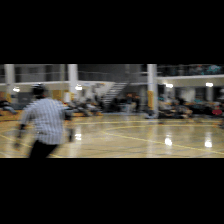

In [27]:
to_gif(sample_video)

In addition to examining this video, you can also display the UCF-101 data. To do this, run the following code:

In [ ]:
# docs-infra: no-execute
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

Next, define the `FrameGenerator` class in order to create an iterable object that can feed data into the TensorFlow data pipeline. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [28]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

Test out the `FrameGenerator` object before wrapping it as a TensorFlow Dataset object. Moreover, for the training dataset, ensure you enable training mode so that the data will be shuffled.

In [29]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 6


Finally, create a TensorFlow data input pipeline. This pipeline that you create from the generator object allows you to feed in data to your deep learning model. In this video pipeline, each element is a single set of frames and its associated label. 

In [30]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)

Check to see that the labels are shuffled. 

In [31]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(8, shape=(), dtype=int16)


tf.Tensor(7, shape=(), dtype=int16)
tf.Tensor(9, shape=(), dtype=int16)


tf.Tensor(4, shape=(), dtype=int16)


tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(6, shape=(), dtype=int16)


tf.Tensor(7, shape=(), dtype=int16)


tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(5, shape=(), dtype=int16)


tf.Tensor(0, shape=(), dtype=int16)


In [32]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

In [33]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()


Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


## Configure the dataset for performance

Use buffered prefetching such that you can yield data from the disk without having I/O become blocking. Two important functions to use while loading data are:

* `Dataset.cache`: keeps the sets of frames in memory after they're loaded off the disk during the first epoch. This function ensures that the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* `Dataset.prefetch`: overlaps data preprocessing and model execution while training.
Refer to [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance) for details.

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

To prepare the data to be fed into the model, use batching as shown below. Notice that when working with video data, such as AVI files, the data should be shaped as a five dimensional object. These dimensions are as follows: `[batch_size, number_of_frames, height, width, channels]`. In comparison, an image would have four dimensions: `[batch_size, height, width, channels]`. The image below is an illustration of how the shape of video data is represented.

![Video data shape](https://www.tensorflow.org/images/tutorials/video/video_data_shape.png)


In [35]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)


Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


## Next steps

Now that you have created a TensorFlow `Dataset` of video frames with their labels, you can use it with a deep learning model. The following classification model that uses a pre-trained [EfficientNet](https://arxiv.org/abs/1905.11946){:.external} trains to high accuracy in a few minutes:

In [36]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds, 
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

    8192/16705208 [..............................] - ETA: 0s

 5038080/16705208 [========>.....................] - ETA: 0s

 8396800/16705208 [==============>...............] - ETA: 0s

16705208/16705208 [==============================] - 0s 0us/step


Epoch 1/10


2023-01-07 02:26:48.407527: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/time_distributed/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


      1/Unknown - 10s 10s/step - loss: 2.3699 - accuracy: 0.0000e+00

      3/Unknown - 10s 28ms/step - loss: 2.2536 - accuracy: 0.0000e+00

      5/Unknown - 10s 29ms/step - loss: 2.4933 - accuracy: 0.0000e+00

      7/Unknown - 10s 29ms/step - loss: 2.4682 - accuracy: 0.0714    

      9/Unknown - 10s 28ms/step - loss: 2.3560 - accuracy: 0.1667

     11/Unknown - 10s 28ms/step - loss: 2.3328 - accuracy: 0.1818

     13/Unknown - 10s 28ms/step - loss: 2.2907 - accuracy: 0.1923

     15/Unknown - 10s 28ms/step - loss: 2.3152 - accuracy: 0.1667

     17/Unknown - 10s 28ms/step - loss: 2.2962 - accuracy: 0.1765

     19/Unknown - 10s 28ms/step - loss: 2.2277 - accuracy: 0.2105

     21/Unknown - 10s 28ms/step - loss: 2.1704 - accuracy: 0.2381

     23/Unknown - 10s 28ms/step - loss: 2.1426 - accuracy: 0.2391

     25/Unknown - 10s 28ms/step - loss: 2.0991 - accuracy: 0.2800

     27/Unknown - 11s 28ms/step - loss: 2.0533 - accuracy: 0.2963

     29/Unknown - 11s 28ms/step - loss: 2.0107 - accuracy: 0.3103

     31/Unknown - 11s 28ms/step - loss: 2.0355 - accuracy: 0.2903

     33/Unknown - 11s 28ms/step - loss: 1.9942 - accuracy: 0.3030

     35/Unknown - 11s 28ms/step - loss: 1.9816 - accuracy: 0.3000

     37/Unknown - 11s 28ms/step - loss: 1.9431 - accuracy: 0.3378

     39/Unknown - 11s 28ms/step - loss: 1.9173 - accuracy: 0.3462

     41/Unknown - 11s 28ms/step - loss: 1.8846 - accuracy: 0.3537

     43/Unknown - 11s 28ms/step - loss: 1.8753 - accuracy: 0.3605

     45/Unknown - 11s 28ms/step - loss: 1.8618 - accuracy: 0.3667

     47/Unknown - 11s 28ms/step - loss: 1.8329 - accuracy: 0.3936

     49/Unknown - 11s 28ms/step - loss: 1.8233 - accuracy: 0.3878

     51/Unknown - 11s 28ms/step - loss: 1.8142 - accuracy: 0.3922

     53/Unknown - 11s 28ms/step - loss: 1.7887 - accuracy: 0.4057

     55/Unknown - 11s 28ms/step - loss: 1.7703 - accuracy: 0.4182

     57/Unknown - 11s 28ms/step - loss: 1.7509 - accuracy: 0.4211

     59/Unknown - 11s 28ms/step - loss: 1.7286 - accuracy: 0.4322

     61/Unknown - 11s 28ms/step - loss: 1.7186 - accuracy: 0.4508

     63/Unknown - 12s 28ms/step - loss: 1.6969 - accuracy: 0.4603

     65/Unknown - 12s 28ms/step - loss: 1.6885 - accuracy: 0.4615

     67/Unknown - 12s 28ms/step - loss: 1.6632 - accuracy: 0.4776

     69/Unknown - 12s 28ms/step - loss: 1.6399 - accuracy: 0.4928

     71/Unknown - 12s 28ms/step - loss: 1.6194 - accuracy: 0.5070

     73/Unknown - 12s 28ms/step - loss: 1.6127 - accuracy: 0.5137

     75/Unknown - 12s 28ms/step - loss: 1.5898 - accuracy: 0.5267

     77/Unknown - 12s 28ms/step - loss: 1.5733 - accuracy: 0.5325

     79/Unknown - 12s 28ms/step - loss: 1.5668 - accuracy: 0.5380

     81/Unknown - 12s 28ms/step - loss: 1.5474 - accuracy: 0.5432

     83/Unknown - 12s 28ms/step - loss: 1.5272 - accuracy: 0.5542

     85/Unknown - 12s 28ms/step - loss: 1.5212 - accuracy: 0.5588

     87/Unknown - 12s 28ms/step - loss: 1.5002 - accuracy: 0.5690

     89/Unknown - 12s 28ms/step - loss: 1.4938 - accuracy: 0.5730

     91/Unknown - 12s 28ms/step - loss: 1.4709 - accuracy: 0.5824

     93/Unknown - 12s 28ms/step - loss: 1.4510 - accuracy: 0.5914

     95/Unknown - 12s 28ms/step - loss: 1.4336 - accuracy: 0.6000

     97/Unknown - 12s 28ms/step - loss: 1.4248 - accuracy: 0.6031

     99/Unknown - 13s 28ms/step - loss: 1.4160 - accuracy: 0.6111

    101/Unknown - 13s 28ms/step - loss: 1.4075 - accuracy: 0.6089

    103/Unknown - 13s 28ms/step - loss: 1.4038 - accuracy: 0.6117

    105/Unknown - 13s 28ms/step - loss: 1.3881 - accuracy: 0.6190

    107/Unknown - 13s 28ms/step - loss: 1.3803 - accuracy: 0.6262

    109/Unknown - 13s 28ms/step - loss: 1.3755 - accuracy: 0.6239

    111/Unknown - 13s 28ms/step - loss: 1.3629 - accuracy: 0.6306

    113/Unknown - 13s 28ms/step - loss: 1.3597 - accuracy: 0.6283

    115/Unknown - 13s 28ms/step - loss: 1.3464 - accuracy: 0.6348

    117/Unknown - 13s 28ms/step - loss: 1.3383 - accuracy: 0.6368

    119/Unknown - 13s 28ms/step - loss: 1.3266 - accuracy: 0.6387

    121/Unknown - 13s 28ms/step - loss: 1.3149 - accuracy: 0.6446

    123/Unknown - 13s 28ms/step - loss: 1.3042 - accuracy: 0.6504

    125/Unknown - 13s 28ms/step - loss: 1.2930 - accuracy: 0.6560

    127/Unknown - 13s 28ms/step - loss: 1.2805 - accuracy: 0.6614

    129/Unknown - 13s 28ms/step - loss: 1.2676 - accuracy: 0.6667

    131/Unknown - 13s 28ms/step - loss: 1.2571 - accuracy: 0.6718

    133/Unknown - 13s 28ms/step - loss: 1.2482 - accuracy: 0.6767

    135/Unknown - 13s 28ms/step - loss: 1.2394 - accuracy: 0.6778

    137/Unknown - 14s 28ms/step - loss: 1.2270 - accuracy: 0.6825

    139/Unknown - 14s 28ms/step - loss: 1.2178 - accuracy: 0.6871

    141/Unknown - 14s 28ms/step - loss: 1.2090 - accuracy: 0.6915

    143/Unknown - 14s 28ms/step - loss: 1.2001 - accuracy: 0.6958

    145/Unknown - 14s 28ms/step - loss: 1.1918 - accuracy: 0.6966

    147/Unknown - 14s 28ms/step - loss: 1.1810 - accuracy: 0.7007

    149/Unknown - 14s 28ms/step - loss: 1.1680 - accuracy: 0.7047

150/150 [==============================] - 18s 55ms/step - loss: 1.1630 - accuracy: 0.7067 - val_loss: 0.4363 - val_accuracy: 0.9500


Epoch 2/10


  1/150 [..............................] - ETA: 4s - loss: 0.3597 - accuracy: 1.0000

  3/150 [..............................] - ETA: 4s - loss: 0.3313 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 3s - loss: 0.3615 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 3s - loss: 0.3101 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 3s - loss: 0.3478 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 3s - loss: 0.3605 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 3s - loss: 0.3270 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 3s - loss: 0.3918 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 3s - loss: 0.4107 - accuracy: 0.9706

 19/150 [==>...........................] - ETA: 3s - loss: 0.4400 - accuracy: 0.9737

 21/150 [===>..........................] - ETA: 3s - loss: 0.4413 - accuracy: 0.9762

 23/150 [===>..........................] - ETA: 3s - loss: 0.4316 - accuracy: 0.9783

 25/150 [====>.........................] - ETA: 3s - loss: 0.4110 - accuracy: 0.9800

 27/150 [====>.........................] - ETA: 3s - loss: 0.3918 - accuracy: 0.9815

 29/150 [====>.........................] - ETA: 3s - loss: 0.4010 - accuracy: 0.9828

 31/150 [=====>........................] - ETA: 3s - loss: 0.3900 - accuracy: 0.9839

 33/150 [=====>........................] - ETA: 3s - loss: 0.3819 - accuracy: 0.9848

 35/150 [======>.......................] - ETA: 3s - loss: 0.3823 - accuracy: 0.9857

 37/150 [======>.......................] - ETA: 3s - loss: 0.3788 - accuracy: 0.9865

 39/150 [======>.......................] - ETA: 3s - loss: 0.3832 - accuracy: 0.9872

 41/150 [=======>......................] - ETA: 3s - loss: 0.3758 - accuracy: 0.9878

 43/150 [=======>......................] - ETA: 2s - loss: 0.3673 - accuracy: 0.9884

 45/150 [========>.....................] - ETA: 2s - loss: 0.3668 - accuracy: 0.9889

 47/150 [========>.....................] - ETA: 2s - loss: 0.3702 - accuracy: 0.9894

 49/150 [========>.....................] - ETA: 2s - loss: 0.3581 - accuracy: 0.9898

 51/150 [=========>....................] - ETA: 2s - loss: 0.3538 - accuracy: 0.9902

 53/150 [=========>....................] - ETA: 2s - loss: 0.3455 - accuracy: 0.9906

 55/150 [==========>...................] - ETA: 2s - loss: 0.3483 - accuracy: 0.9909

 57/150 [==========>...................] - ETA: 2s - loss: 0.3452 - accuracy: 0.9912

 59/150 [==========>...................] - ETA: 2s - loss: 0.3480 - accuracy: 0.9831

 61/150 [===========>..................] - ETA: 2s - loss: 0.3503 - accuracy: 0.9836

 63/150 [===========>..................] - ETA: 2s - loss: 0.3548 - accuracy: 0.9841

 65/150 [============>.................] - ETA: 2s - loss: 0.3541 - accuracy: 0.9769

 67/150 [============>.................] - ETA: 2s - loss: 0.3528 - accuracy: 0.9776

 69/150 [============>.................] - ETA: 2s - loss: 0.3533 - accuracy: 0.9710

 71/150 [=============>................] - ETA: 2s - loss: 0.3507 - accuracy: 0.9718

 73/150 [=============>................] - ETA: 2s - loss: 0.3501 - accuracy: 0.9726

 75/150 [==============>...............] - ETA: 2s - loss: 0.3490 - accuracy: 0.9733

 77/150 [==============>...............] - ETA: 2s - loss: 0.3468 - accuracy: 0.9740

 79/150 [==============>...............] - ETA: 1s - loss: 0.3488 - accuracy: 0.9684

 81/150 [===============>..............] - ETA: 1s - loss: 0.3441 - accuracy: 0.9691

 83/150 [===============>..............] - ETA: 1s - loss: 0.3388 - accuracy: 0.9699

 85/150 [================>.............] - ETA: 1s - loss: 0.3361 - accuracy: 0.9706

 87/150 [================>.............] - ETA: 1s - loss: 0.3368 - accuracy: 0.9713

 89/150 [================>.............] - ETA: 1s - loss: 0.3369 - accuracy: 0.9719

 91/150 [=================>............] - ETA: 1s - loss: 0.3378 - accuracy: 0.9725

 93/150 [=================>............] - ETA: 1s - loss: 0.3351 - accuracy: 0.9731

 95/150 [==================>...........] - ETA: 1s - loss: 0.3333 - accuracy: 0.9737

 97/150 [==================>...........] - ETA: 1s - loss: 0.3342 - accuracy: 0.9691

 99/150 [==================>...........] - ETA: 1s - loss: 0.3320 - accuracy: 0.9697

101/150 [===================>..........] - ETA: 1s - loss: 0.3345 - accuracy: 0.9703

103/150 [===================>..........] - ETA: 1s - loss: 0.3353 - accuracy: 0.9709

105/150 [====================>.........] - ETA: 1s - loss: 0.3378 - accuracy: 0.9667

107/150 [====================>.........] - ETA: 1s - loss: 0.3427 - accuracy: 0.9673

109/150 [====================>.........] - ETA: 1s - loss: 0.3417 - accuracy: 0.9679

111/150 [=====================>........] - ETA: 1s - loss: 0.3397 - accuracy: 0.9685

113/150 [=====================>........] - ETA: 1s - loss: 0.3396 - accuracy: 0.9690

115/150 [======================>.......] - ETA: 0s - loss: 0.3379 - accuracy: 0.9696

117/150 [======================>.......] - ETA: 0s - loss: 0.3379 - accuracy: 0.9701

119/150 [======================>.......] - ETA: 0s - loss: 0.3345 - accuracy: 0.9706

121/150 [=======================>......] - ETA: 0s - loss: 0.3422 - accuracy: 0.9669

123/150 [=======================>......] - ETA: 0s - loss: 0.3455 - accuracy: 0.9634

125/150 [========================>.....] - ETA: 0s - loss: 0.3456 - accuracy: 0.9640

127/150 [========================>.....] - ETA: 0s - loss: 0.3441 - accuracy: 0.9646

129/150 [========================>.....] - ETA: 0s - loss: 0.3414 - accuracy: 0.9651

131/150 [=========================>....] - ETA: 0s - loss: 0.3424 - accuracy: 0.9656

133/150 [=========================>....] - ETA: 0s - loss: 0.3403 - accuracy: 0.9662

135/150 [==========================>...] - ETA: 0s - loss: 0.3414 - accuracy: 0.9667

137/150 [==========================>...] - ETA: 0s - loss: 0.3396 - accuracy: 0.9672

139/150 [==========================>...] - ETA: 0s - loss: 0.3380 - accuracy: 0.9676

141/150 [===========================>..] - ETA: 0s - loss: 0.3358 - accuracy: 0.9681

143/150 [===========================>..] - ETA: 0s - loss: 0.3353 - accuracy: 0.9685

145/150 [============================>.] - ETA: 0s - loss: 0.3367 - accuracy: 0.9690

147/150 [============================>.] - ETA: 0s - loss: 0.3402 - accuracy: 0.9660

149/150 [============================>.] - ETA: 0s - loss: 0.3397 - accuracy: 0.9664

150/150 [==============================] - 6s 37ms/step - loss: 0.3393 - accuracy: 0.9667 - val_loss: 0.2378 - val_accuracy: 0.9700


Epoch 3/10


  1/150 [..............................] - ETA: 4s - loss: 0.1288 - accuracy: 1.0000

  3/150 [..............................] - ETA: 4s - loss: 0.2384 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 4s - loss: 0.2032 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 3s - loss: 0.1741 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 3s - loss: 0.1766 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 3s - loss: 0.1870 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 3s - loss: 0.2266 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 3s - loss: 0.2138 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 3s - loss: 0.2064 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 3s - loss: 0.1957 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 3s - loss: 0.2067 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 3s - loss: 0.1940 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 3s - loss: 0.2095 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 3s - loss: 0.2096 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 3s - loss: 0.2030 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 3s - loss: 0.2330 - accuracy: 0.9839

 33/150 [=====>........................] - ETA: 3s - loss: 0.2279 - accuracy: 0.9848

 35/150 [======>.......................] - ETA: 3s - loss: 0.2237 - accuracy: 0.9857

 37/150 [======>.......................] - ETA: 3s - loss: 0.2170 - accuracy: 0.9865

 39/150 [======>.......................] - ETA: 3s - loss: 0.2209 - accuracy: 0.9872

 41/150 [=======>......................] - ETA: 3s - loss: 0.2135 - accuracy: 0.9878

 43/150 [=======>......................] - ETA: 2s - loss: 0.2114 - accuracy: 0.9884

 45/150 [========>.....................] - ETA: 2s - loss: 0.2146 - accuracy: 0.9889

 47/150 [========>.....................] - ETA: 2s - loss: 0.2144 - accuracy: 0.9894

 49/150 [========>.....................] - ETA: 2s - loss: 0.2207 - accuracy: 0.9898

 51/150 [=========>....................] - ETA: 2s - loss: 0.2224 - accuracy: 0.9902

 53/150 [=========>....................] - ETA: 2s - loss: 0.2213 - accuracy: 0.9906

 55/150 [==========>...................] - ETA: 2s - loss: 0.2252 - accuracy: 0.9909

 57/150 [==========>...................] - ETA: 2s - loss: 0.2237 - accuracy: 0.9912

 59/150 [==========>...................] - ETA: 2s - loss: 0.2220 - accuracy: 0.9915

 61/150 [===========>..................] - ETA: 2s - loss: 0.2206 - accuracy: 0.9918

 63/150 [===========>..................] - ETA: 2s - loss: 0.2156 - accuracy: 0.9921

 65/150 [============>.................] - ETA: 2s - loss: 0.2118 - accuracy: 0.9923

 67/150 [============>.................] - ETA: 2s - loss: 0.2094 - accuracy: 0.9925

 69/150 [============>.................] - ETA: 2s - loss: 0.2132 - accuracy: 0.9928

 71/150 [=============>................] - ETA: 2s - loss: 0.2122 - accuracy: 0.9930

 73/150 [=============>................] - ETA: 2s - loss: 0.2183 - accuracy: 0.9932

 75/150 [==============>...............] - ETA: 2s - loss: 0.2156 - accuracy: 0.9933

 77/150 [==============>...............] - ETA: 2s - loss: 0.2129 - accuracy: 0.9935

 79/150 [==============>...............] - ETA: 1s - loss: 0.2110 - accuracy: 0.9937

 81/150 [===============>..............] - ETA: 1s - loss: 0.2083 - accuracy: 0.9938

 83/150 [===============>..............] - ETA: 1s - loss: 0.2071 - accuracy: 0.9940

 85/150 [================>.............] - ETA: 1s - loss: 0.2089 - accuracy: 0.9941

 87/150 [================>.............] - ETA: 1s - loss: 0.2067 - accuracy: 0.9943

 89/150 [================>.............] - ETA: 1s - loss: 0.2093 - accuracy: 0.9944

 91/150 [=================>............] - ETA: 1s - loss: 0.2071 - accuracy: 0.9945

 93/150 [=================>............] - ETA: 1s - loss: 0.2072 - accuracy: 0.9946

 95/150 [==================>...........] - ETA: 1s - loss: 0.2040 - accuracy: 0.9947

 97/150 [==================>...........] - ETA: 1s - loss: 0.2039 - accuracy: 0.9948

 99/150 [==================>...........] - ETA: 1s - loss: 0.2020 - accuracy: 0.9949

101/150 [===================>..........] - ETA: 1s - loss: 0.1998 - accuracy: 0.9950

103/150 [===================>..........] - ETA: 1s - loss: 0.1989 - accuracy: 0.9951

105/150 [====================>.........] - ETA: 1s - loss: 0.1995 - accuracy: 0.9952

107/150 [====================>.........] - ETA: 1s - loss: 0.2027 - accuracy: 0.9953

109/150 [====================>.........] - ETA: 1s - loss: 0.2028 - accuracy: 0.9954

111/150 [=====================>........] - ETA: 1s - loss: 0.2021 - accuracy: 0.9955

113/150 [=====================>........] - ETA: 1s - loss: 0.1995 - accuracy: 0.9956

115/150 [======================>.......] - ETA: 0s - loss: 0.2024 - accuracy: 0.9913

117/150 [======================>.......] - ETA: 0s - loss: 0.2012 - accuracy: 0.9915

119/150 [======================>.......] - ETA: 0s - loss: 0.1993 - accuracy: 0.9916

121/150 [=======================>......] - ETA: 0s - loss: 0.2007 - accuracy: 0.9917

123/150 [=======================>......] - ETA: 0s - loss: 0.1985 - accuracy: 0.9919

125/150 [========================>.....] - ETA: 0s - loss: 0.1983 - accuracy: 0.9920

127/150 [========================>.....] - ETA: 0s - loss: 0.1968 - accuracy: 0.9921

129/150 [========================>.....] - ETA: 0s - loss: 0.1953 - accuracy: 0.9922

131/150 [=========================>....] - ETA: 0s - loss: 0.1928 - accuracy: 0.9924

133/150 [=========================>....] - ETA: 0s - loss: 0.1936 - accuracy: 0.9925

135/150 [==========================>...] - ETA: 0s - loss: 0.1920 - accuracy: 0.9926

137/150 [==========================>...] - ETA: 0s - loss: 0.1902 - accuracy: 0.9927

139/150 [==========================>...] - ETA: 0s - loss: 0.1922 - accuracy: 0.9928

141/150 [===========================>..] - ETA: 0s - loss: 0.1905 - accuracy: 0.9929

143/150 [===========================>..] - ETA: 0s - loss: 0.1896 - accuracy: 0.9930

145/150 [============================>.] - ETA: 0s - loss: 0.1881 - accuracy: 0.9931

147/150 [============================>.] - ETA: 0s - loss: 0.1881 - accuracy: 0.9932

149/150 [============================>.] - ETA: 0s - loss: 0.1868 - accuracy: 0.9933

150/150 [==============================] - 5s 37ms/step - loss: 0.1862 - accuracy: 0.9933 - val_loss: 0.1863 - val_accuracy: 0.9600


Epoch 4/10


  1/150 [..............................] - ETA: 4s - loss: 0.0564 - accuracy: 1.0000

  3/150 [..............................] - ETA: 4s - loss: 0.0871 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 3s - loss: 0.1057 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 3s - loss: 0.1109 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 3s - loss: 0.1621 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 3s - loss: 0.1644 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 3s - loss: 0.1535 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 3s - loss: 0.1349 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 3s - loss: 0.1362 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 3s - loss: 0.1317 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 3s - loss: 0.1285 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 3s - loss: 0.1242 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 3s - loss: 0.1292 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 3s - loss: 0.1450 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 3s - loss: 0.1384 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 3s - loss: 0.1342 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 3s - loss: 0.1351 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 3s - loss: 0.1348 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 3s - loss: 0.1297 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 3s - loss: 0.1241 - accuracy: 1.0000

 41/150 [=======>......................] - ETA: 2s - loss: 0.1264 - accuracy: 1.0000

 43/150 [=======>......................] - ETA: 2s - loss: 0.1257 - accuracy: 1.0000

 45/150 [========>.....................] - ETA: 2s - loss: 0.1235 - accuracy: 1.0000

 47/150 [========>.....................] - ETA: 2s - loss: 0.1216 - accuracy: 1.0000

 49/150 [========>.....................] - ETA: 2s - loss: 0.1320 - accuracy: 1.0000

 51/150 [=========>....................] - ETA: 2s - loss: 0.1297 - accuracy: 1.0000

 53/150 [=========>....................] - ETA: 2s - loss: 0.1284 - accuracy: 1.0000

 55/150 [==========>...................] - ETA: 2s - loss: 0.1344 - accuracy: 1.0000

 57/150 [==========>...................] - ETA: 2s - loss: 0.1357 - accuracy: 1.0000

 59/150 [==========>...................] - ETA: 2s - loss: 0.1354 - accuracy: 1.0000

 61/150 [===========>..................] - ETA: 2s - loss: 0.1323 - accuracy: 1.0000

 63/150 [===========>..................] - ETA: 2s - loss: 0.1293 - accuracy: 1.0000

 65/150 [============>.................] - ETA: 2s - loss: 0.1281 - accuracy: 1.0000

 67/150 [============>.................] - ETA: 2s - loss: 0.1251 - accuracy: 1.0000

 69/150 [============>.................] - ETA: 2s - loss: 0.1231 - accuracy: 1.0000

 71/150 [=============>................] - ETA: 2s - loss: 0.1211 - accuracy: 1.0000

 73/150 [=============>................] - ETA: 2s - loss: 0.1231 - accuracy: 1.0000

 75/150 [==============>...............] - ETA: 2s - loss: 0.1237 - accuracy: 1.0000

 77/150 [==============>...............] - ETA: 2s - loss: 0.1259 - accuracy: 1.0000

 79/150 [==============>...............] - ETA: 1s - loss: 0.1270 - accuracy: 1.0000

 81/150 [===============>..............] - ETA: 1s - loss: 0.1289 - accuracy: 1.0000

 83/150 [===============>..............] - ETA: 1s - loss: 0.1299 - accuracy: 1.0000

 85/150 [================>.............] - ETA: 1s - loss: 0.1294 - accuracy: 1.0000

 87/150 [================>.............] - ETA: 1s - loss: 0.1282 - accuracy: 1.0000

 89/150 [================>.............] - ETA: 1s - loss: 0.1278 - accuracy: 1.0000

 91/150 [=================>............] - ETA: 1s - loss: 0.1289 - accuracy: 1.0000

 93/150 [=================>............] - ETA: 1s - loss: 0.1280 - accuracy: 1.0000

 95/150 [==================>...........] - ETA: 1s - loss: 0.1304 - accuracy: 1.0000

 97/150 [==================>...........] - ETA: 1s - loss: 0.1289 - accuracy: 1.0000

 99/150 [==================>...........] - ETA: 1s - loss: 0.1284 - accuracy: 1.0000

101/150 [===================>..........] - ETA: 1s - loss: 0.1263 - accuracy: 1.0000

103/150 [===================>..........] - ETA: 1s - loss: 0.1357 - accuracy: 0.9951

105/150 [====================>.........] - ETA: 1s - loss: 0.1369 - accuracy: 0.9952

107/150 [====================>.........] - ETA: 1s - loss: 0.1352 - accuracy: 0.9953

109/150 [====================>.........] - ETA: 1s - loss: 0.1343 - accuracy: 0.9954

111/150 [=====================>........] - ETA: 1s - loss: 0.1329 - accuracy: 0.9955

113/150 [=====================>........] - ETA: 1s - loss: 0.1321 - accuracy: 0.9956

115/150 [======================>.......] - ETA: 0s - loss: 0.1331 - accuracy: 0.9957

117/150 [======================>.......] - ETA: 0s - loss: 0.1330 - accuracy: 0.9957

119/150 [======================>.......] - ETA: 0s - loss: 0.1324 - accuracy: 0.9958

121/150 [=======================>......] - ETA: 0s - loss: 0.1351 - accuracy: 0.9959

123/150 [=======================>......] - ETA: 0s - loss: 0.1338 - accuracy: 0.9959

125/150 [========================>.....] - ETA: 0s - loss: 0.1325 - accuracy: 0.9960

127/150 [========================>.....] - ETA: 0s - loss: 0.1310 - accuracy: 0.9961

129/150 [========================>.....] - ETA: 0s - loss: 0.1292 - accuracy: 0.9961

131/150 [=========================>....] - ETA: 0s - loss: 0.1283 - accuracy: 0.9962

133/150 [=========================>....] - ETA: 0s - loss: 0.1276 - accuracy: 0.9962

135/150 [==========================>...] - ETA: 0s - loss: 0.1277 - accuracy: 0.9963

137/150 [==========================>...] - ETA: 0s - loss: 0.1269 - accuracy: 0.9964

139/150 [==========================>...] - ETA: 0s - loss: 0.1281 - accuracy: 0.9964

141/150 [===========================>..] - ETA: 0s - loss: 0.1293 - accuracy: 0.9965

143/150 [===========================>..] - ETA: 0s - loss: 0.1286 - accuracy: 0.9965

145/150 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9966

147/150 [============================>.] - ETA: 0s - loss: 0.1279 - accuracy: 0.9966

149/150 [============================>.] - ETA: 0s - loss: 0.1268 - accuracy: 0.9966

150/150 [==============================] - 6s 37ms/step - loss: 0.1264 - accuracy: 0.9967 - val_loss: 0.1413 - val_accuracy: 0.9600


Epoch 5/10


  1/150 [..............................] - ETA: 4s - loss: 0.0324 - accuracy: 1.0000

  3/150 [..............................] - ETA: 4s - loss: 0.0701 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 3s - loss: 0.1108 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 3s - loss: 0.0901 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 3s - loss: 0.0807 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 3s - loss: 0.0745 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 3s - loss: 0.0882 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 3s - loss: 0.1022 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 3s - loss: 0.0952 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 3s - loss: 0.1018 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 3s - loss: 0.1019 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 3s - loss: 0.0944 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 3s - loss: 0.0927 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 3s - loss: 0.1218 - accuracy: 0.9815

 29/150 [====>.........................] - ETA: 3s - loss: 0.1173 - accuracy: 0.9828

 31/150 [=====>........................] - ETA: 3s - loss: 0.1148 - accuracy: 0.9839

 33/150 [=====>........................] - ETA: 3s - loss: 0.1197 - accuracy: 0.9848

 35/150 [======>.......................] - ETA: 3s - loss: 0.1207 - accuracy: 0.9857

 37/150 [======>.......................] - ETA: 3s - loss: 0.1204 - accuracy: 0.9865

 39/150 [======>.......................] - ETA: 3s - loss: 0.1165 - accuracy: 0.9872

 41/150 [=======>......................] - ETA: 2s - loss: 0.1140 - accuracy: 0.9878

 43/150 [=======>......................] - ETA: 2s - loss: 0.1137 - accuracy: 0.9884

 45/150 [========>.....................] - ETA: 2s - loss: 0.1095 - accuracy: 0.9889

 47/150 [========>.....................] - ETA: 2s - loss: 0.1137 - accuracy: 0.9894

 49/150 [========>.....................] - ETA: 2s - loss: 0.1128 - accuracy: 0.9898

 51/150 [=========>....................] - ETA: 2s - loss: 0.1158 - accuracy: 0.9902

 53/150 [=========>....................] - ETA: 2s - loss: 0.1123 - accuracy: 0.9906

 55/150 [==========>...................] - ETA: 2s - loss: 0.1146 - accuracy: 0.9909

 57/150 [==========>...................] - ETA: 2s - loss: 0.1151 - accuracy: 0.9912

 59/150 [==========>...................] - ETA: 2s - loss: 0.1120 - accuracy: 0.9915

 61/150 [===========>..................] - ETA: 2s - loss: 0.1101 - accuracy: 0.9918

 63/150 [===========>..................] - ETA: 2s - loss: 0.1087 - accuracy: 0.9921

 65/150 [============>.................] - ETA: 2s - loss: 0.1085 - accuracy: 0.9923

 67/150 [============>.................] - ETA: 2s - loss: 0.1077 - accuracy: 0.9925

 69/150 [============>.................] - ETA: 2s - loss: 0.1054 - accuracy: 0.9928

 71/150 [=============>................] - ETA: 2s - loss: 0.1034 - accuracy: 0.9930

 73/150 [=============>................] - ETA: 2s - loss: 0.1039 - accuracy: 0.9932

 75/150 [==============>...............] - ETA: 2s - loss: 0.1032 - accuracy: 0.9933

 77/150 [==============>...............] - ETA: 2s - loss: 0.1026 - accuracy: 0.9935

 79/150 [==============>...............] - ETA: 1s - loss: 0.1031 - accuracy: 0.9937

 81/150 [===============>..............] - ETA: 1s - loss: 0.1048 - accuracy: 0.9938

 83/150 [===============>..............] - ETA: 1s - loss: 0.1027 - accuracy: 0.9940

 85/150 [================>.............] - ETA: 1s - loss: 0.1047 - accuracy: 0.9941

 87/150 [================>.............] - ETA: 1s - loss: 0.1039 - accuracy: 0.9943

 89/150 [================>.............] - ETA: 1s - loss: 0.1026 - accuracy: 0.9944

 91/150 [=================>............] - ETA: 1s - loss: 0.1015 - accuracy: 0.9945

 93/150 [=================>............] - ETA: 1s - loss: 0.1000 - accuracy: 0.9946

 95/150 [==================>...........] - ETA: 1s - loss: 0.0985 - accuracy: 0.9947

 97/150 [==================>...........] - ETA: 1s - loss: 0.0979 - accuracy: 0.9948

 99/150 [==================>...........] - ETA: 1s - loss: 0.0969 - accuracy: 0.9949

101/150 [===================>..........] - ETA: 1s - loss: 0.0960 - accuracy: 0.9950

103/150 [===================>..........] - ETA: 1s - loss: 0.0947 - accuracy: 0.9951

105/150 [====================>.........] - ETA: 1s - loss: 0.0946 - accuracy: 0.9952

107/150 [====================>.........] - ETA: 1s - loss: 0.0932 - accuracy: 0.9953

109/150 [====================>.........] - ETA: 1s - loss: 0.0925 - accuracy: 0.9954

111/150 [=====================>........] - ETA: 1s - loss: 0.0925 - accuracy: 0.9955

113/150 [=====================>........] - ETA: 1s - loss: 0.0913 - accuracy: 0.9956

115/150 [======================>.......] - ETA: 0s - loss: 0.0915 - accuracy: 0.9957

117/150 [======================>.......] - ETA: 0s - loss: 0.0909 - accuracy: 0.9957

119/150 [======================>.......] - ETA: 0s - loss: 0.0912 - accuracy: 0.9958

121/150 [=======================>......] - ETA: 0s - loss: 0.0914 - accuracy: 0.9959

123/150 [=======================>......] - ETA: 0s - loss: 0.0908 - accuracy: 0.9959

125/150 [========================>.....] - ETA: 0s - loss: 0.0903 - accuracy: 0.9960

127/150 [========================>.....] - ETA: 0s - loss: 0.0920 - accuracy: 0.9961

129/150 [========================>.....] - ETA: 0s - loss: 0.0922 - accuracy: 0.9961

131/150 [=========================>....] - ETA: 0s - loss: 0.0915 - accuracy: 0.9962

133/150 [=========================>....] - ETA: 0s - loss: 0.0911 - accuracy: 0.9962

135/150 [==========================>...] - ETA: 0s - loss: 0.0909 - accuracy: 0.9963

137/150 [==========================>...] - ETA: 0s - loss: 0.0903 - accuracy: 0.9964

139/150 [==========================>...] - ETA: 0s - loss: 0.0897 - accuracy: 0.9964

141/150 [===========================>..] - ETA: 0s - loss: 0.0887 - accuracy: 0.9965

143/150 [===========================>..] - ETA: 0s - loss: 0.0912 - accuracy: 0.9965

145/150 [============================>.] - ETA: 0s - loss: 0.0916 - accuracy: 0.9966

147/150 [============================>.] - ETA: 0s - loss: 0.0920 - accuracy: 0.9966

149/150 [============================>.] - ETA: 0s - loss: 0.0916 - accuracy: 0.9966

150/150 [==============================] - 5s 37ms/step - loss: 0.0913 - accuracy: 0.9967 - val_loss: 0.1253 - val_accuracy: 0.9600


Epoch 6/10


  1/150 [..............................] - ETA: 4s - loss: 0.0124 - accuracy: 1.0000

  3/150 [..............................] - ETA: 4s - loss: 0.0202 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 3s - loss: 0.0895 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 3s - loss: 0.0964 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 3s - loss: 0.0825 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 3s - loss: 0.0834 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 3s - loss: 0.0727 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 3s - loss: 0.0808 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 3s - loss: 0.0730 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 3s - loss: 0.0751 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 3s - loss: 0.0728 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 3s - loss: 0.0678 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 3s - loss: 0.0759 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 3s - loss: 0.0754 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 3s - loss: 0.0734 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 3s - loss: 0.0756 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 3s - loss: 0.0809 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 3s - loss: 0.0828 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 3s - loss: 0.0842 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 3s - loss: 0.0827 - accuracy: 1.0000

 41/150 [=======>......................] - ETA: 3s - loss: 0.0813 - accuracy: 1.0000

 43/150 [=======>......................] - ETA: 2s - loss: 0.0826 - accuracy: 1.0000

 45/150 [========>.....................] - ETA: 2s - loss: 0.0830 - accuracy: 1.0000

 47/150 [========>.....................] - ETA: 2s - loss: 0.0817 - accuracy: 1.0000

 49/150 [========>.....................] - ETA: 2s - loss: 0.0809 - accuracy: 1.0000

 51/150 [=========>....................] - ETA: 2s - loss: 0.0810 - accuracy: 1.0000

 53/150 [=========>....................] - ETA: 2s - loss: 0.0789 - accuracy: 1.0000

 55/150 [==========>...................] - ETA: 2s - loss: 0.0772 - accuracy: 1.0000

 57/150 [==========>...................] - ETA: 2s - loss: 0.0763 - accuracy: 1.0000

 59/150 [==========>...................] - ETA: 2s - loss: 0.0743 - accuracy: 1.0000

 61/150 [===========>..................] - ETA: 2s - loss: 0.0728 - accuracy: 1.0000

 63/150 [===========>..................] - ETA: 2s - loss: 0.0735 - accuracy: 1.0000

 65/150 [============>.................] - ETA: 2s - loss: 0.0732 - accuracy: 1.0000

 67/150 [============>.................] - ETA: 2s - loss: 0.0729 - accuracy: 1.0000

 69/150 [============>.................] - ETA: 2s - loss: 0.0731 - accuracy: 1.0000

 71/150 [=============>................] - ETA: 2s - loss: 0.0722 - accuracy: 1.0000

 73/150 [=============>................] - ETA: 2s - loss: 0.0712 - accuracy: 1.0000

 75/150 [==============>...............] - ETA: 2s - loss: 0.0707 - accuracy: 1.0000

 77/150 [==============>...............] - ETA: 2s - loss: 0.0704 - accuracy: 1.0000

 79/150 [==============>...............] - ETA: 1s - loss: 0.0694 - accuracy: 1.0000

 81/150 [===============>..............] - ETA: 1s - loss: 0.0687 - accuracy: 1.0000

 83/150 [===============>..............] - ETA: 1s - loss: 0.0771 - accuracy: 0.9940

 85/150 [================>.............] - ETA: 1s - loss: 0.0757 - accuracy: 0.9941

 87/150 [================>.............] - ETA: 1s - loss: 0.0746 - accuracy: 0.9943

 89/150 [================>.............] - ETA: 1s - loss: 0.0738 - accuracy: 0.9944

 91/150 [=================>............] - ETA: 1s - loss: 0.0745 - accuracy: 0.9945

 93/150 [=================>............] - ETA: 1s - loss: 0.0742 - accuracy: 0.9946

 95/150 [==================>...........] - ETA: 1s - loss: 0.0730 - accuracy: 0.9947

 97/150 [==================>...........] - ETA: 1s - loss: 0.0722 - accuracy: 0.9948

 99/150 [==================>...........] - ETA: 1s - loss: 0.0717 - accuracy: 0.9949

101/150 [===================>..........] - ETA: 1s - loss: 0.0708 - accuracy: 0.9950

103/150 [===================>..........] - ETA: 1s - loss: 0.0699 - accuracy: 0.9951

105/150 [====================>.........] - ETA: 1s - loss: 0.0710 - accuracy: 0.9952

107/150 [====================>.........] - ETA: 1s - loss: 0.0699 - accuracy: 0.9953

109/150 [====================>.........] - ETA: 1s - loss: 0.0701 - accuracy: 0.9954

111/150 [=====================>........] - ETA: 1s - loss: 0.0690 - accuracy: 0.9955

113/150 [=====================>........] - ETA: 1s - loss: 0.0694 - accuracy: 0.9956

115/150 [======================>.......] - ETA: 0s - loss: 0.0688 - accuracy: 0.9957

117/150 [======================>.......] - ETA: 0s - loss: 0.0699 - accuracy: 0.9957

119/150 [======================>.......] - ETA: 0s - loss: 0.0697 - accuracy: 0.9958

121/150 [=======================>......] - ETA: 0s - loss: 0.0689 - accuracy: 0.9959

123/150 [=======================>......] - ETA: 0s - loss: 0.0686 - accuracy: 0.9959

125/150 [========================>.....] - ETA: 0s - loss: 0.0683 - accuracy: 0.9960

127/150 [========================>.....] - ETA: 0s - loss: 0.0691 - accuracy: 0.9961

129/150 [========================>.....] - ETA: 0s - loss: 0.0686 - accuracy: 0.9961

131/150 [=========================>....] - ETA: 0s - loss: 0.0686 - accuracy: 0.9962

133/150 [=========================>....] - ETA: 0s - loss: 0.0685 - accuracy: 0.9962

135/150 [==========================>...] - ETA: 0s - loss: 0.0684 - accuracy: 0.9963

137/150 [==========================>...] - ETA: 0s - loss: 0.0677 - accuracy: 0.9964

139/150 [==========================>...] - ETA: 0s - loss: 0.0675 - accuracy: 0.9964

141/150 [===========================>..] - ETA: 0s - loss: 0.0680 - accuracy: 0.9965

143/150 [===========================>..] - ETA: 0s - loss: 0.0693 - accuracy: 0.9965

145/150 [============================>.] - ETA: 0s - loss: 0.0685 - accuracy: 0.9966

147/150 [============================>.] - ETA: 0s - loss: 0.0686 - accuracy: 0.9966

149/150 [============================>.] - ETA: 0s - loss: 0.0686 - accuracy: 0.9966

150/150 [==============================] - 6s 37ms/step - loss: 0.0682 - accuracy: 0.9967 - val_loss: 0.1083 - val_accuracy: 0.9600


Epoch 7/10


  1/150 [..............................] - ETA: 4s - loss: 0.0243 - accuracy: 1.0000

  3/150 [..............................] - ETA: 4s - loss: 0.0754 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 3s - loss: 0.0562 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 3s - loss: 0.0487 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 3s - loss: 0.0472 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 3s - loss: 0.0487 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 3s - loss: 0.0506 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 3s - loss: 0.0466 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 3s - loss: 0.0462 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 3s - loss: 0.0427 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 3s - loss: 0.0443 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 3s - loss: 0.0467 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 3s - loss: 0.0472 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 3s - loss: 0.0450 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 3s - loss: 0.0433 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 3s - loss: 0.0415 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 3s - loss: 0.0425 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 3s - loss: 0.0473 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 3s - loss: 0.0460 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 3s - loss: 0.0572 - accuracy: 0.9872

 41/150 [=======>......................] - ETA: 3s - loss: 0.0644 - accuracy: 0.9878

 43/150 [=======>......................] - ETA: 2s - loss: 0.0636 - accuracy: 0.9884

 45/150 [========>.....................] - ETA: 2s - loss: 0.0617 - accuracy: 0.9889

 47/150 [========>.....................] - ETA: 2s - loss: 0.0604 - accuracy: 0.9894

 49/150 [========>.....................] - ETA: 2s - loss: 0.0586 - accuracy: 0.9898

 51/150 [=========>....................] - ETA: 2s - loss: 0.0583 - accuracy: 0.9902

 53/150 [=========>....................] - ETA: 2s - loss: 0.0577 - accuracy: 0.9906

 55/150 [==========>...................] - ETA: 2s - loss: 0.0580 - accuracy: 0.9909

 57/150 [==========>...................] - ETA: 2s - loss: 0.0575 - accuracy: 0.9912

 59/150 [==========>...................] - ETA: 2s - loss: 0.0563 - accuracy: 0.9915

 61/150 [===========>..................] - ETA: 2s - loss: 0.0558 - accuracy: 0.9918

 63/150 [===========>..................] - ETA: 2s - loss: 0.0555 - accuracy: 0.9921

 65/150 [============>.................] - ETA: 2s - loss: 0.0587 - accuracy: 0.9923

 67/150 [============>.................] - ETA: 2s - loss: 0.0571 - accuracy: 0.9925

 69/150 [============>.................] - ETA: 2s - loss: 0.0587 - accuracy: 0.9928

 71/150 [=============>................] - ETA: 2s - loss: 0.0597 - accuracy: 0.9930

 73/150 [=============>................] - ETA: 2s - loss: 0.0596 - accuracy: 0.9932

 75/150 [==============>...............] - ETA: 2s - loss: 0.0587 - accuracy: 0.9933

 77/150 [==============>...............] - ETA: 2s - loss: 0.0576 - accuracy: 0.9935

 79/150 [==============>...............] - ETA: 1s - loss: 0.0578 - accuracy: 0.9937

 81/150 [===============>..............] - ETA: 1s - loss: 0.0577 - accuracy: 0.9938

 83/150 [===============>..............] - ETA: 1s - loss: 0.0604 - accuracy: 0.9940

 85/150 [================>.............] - ETA: 1s - loss: 0.0605 - accuracy: 0.9941

 87/150 [================>.............] - ETA: 1s - loss: 0.0599 - accuracy: 0.9943

 89/150 [================>.............] - ETA: 1s - loss: 0.0596 - accuracy: 0.9944

 91/150 [=================>............] - ETA: 1s - loss: 0.0601 - accuracy: 0.9945

 93/150 [=================>............] - ETA: 1s - loss: 0.0594 - accuracy: 0.9946

 95/150 [==================>...........] - ETA: 1s - loss: 0.0592 - accuracy: 0.9947

 97/150 [==================>...........] - ETA: 1s - loss: 0.0589 - accuracy: 0.9948

 99/150 [==================>...........] - ETA: 1s - loss: 0.0594 - accuracy: 0.9949

101/150 [===================>..........] - ETA: 1s - loss: 0.0583 - accuracy: 0.9950

103/150 [===================>..........] - ETA: 1s - loss: 0.0588 - accuracy: 0.9951

105/150 [====================>.........] - ETA: 1s - loss: 0.0582 - accuracy: 0.9952

107/150 [====================>.........] - ETA: 1s - loss: 0.0575 - accuracy: 0.9953

109/150 [====================>.........] - ETA: 1s - loss: 0.0567 - accuracy: 0.9954

111/150 [=====================>........] - ETA: 1s - loss: 0.0564 - accuracy: 0.9955

113/150 [=====================>........] - ETA: 1s - loss: 0.0560 - accuracy: 0.9956

115/150 [======================>.......] - ETA: 0s - loss: 0.0554 - accuracy: 0.9957

117/150 [======================>.......] - ETA: 0s - loss: 0.0560 - accuracy: 0.9957

119/150 [======================>.......] - ETA: 0s - loss: 0.0553 - accuracy: 0.9958

121/150 [=======================>......] - ETA: 0s - loss: 0.0550 - accuracy: 0.9959

123/150 [=======================>......] - ETA: 0s - loss: 0.0547 - accuracy: 0.9959

125/150 [========================>.....] - ETA: 0s - loss: 0.0548 - accuracy: 0.9960

127/150 [========================>.....] - ETA: 0s - loss: 0.0541 - accuracy: 0.9961

129/150 [========================>.....] - ETA: 0s - loss: 0.0537 - accuracy: 0.9961

131/150 [=========================>....] - ETA: 0s - loss: 0.0532 - accuracy: 0.9962

133/150 [=========================>....] - ETA: 0s - loss: 0.0544 - accuracy: 0.9962

135/150 [==========================>...] - ETA: 0s - loss: 0.0538 - accuracy: 0.9963

137/150 [==========================>...] - ETA: 0s - loss: 0.0544 - accuracy: 0.9964

139/150 [==========================>...] - ETA: 0s - loss: 0.0546 - accuracy: 0.9964

141/150 [===========================>..] - ETA: 0s - loss: 0.0545 - accuracy: 0.9965

143/150 [===========================>..] - ETA: 0s - loss: 0.0541 - accuracy: 0.9965

145/150 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9966

147/150 [============================>.] - ETA: 0s - loss: 0.0531 - accuracy: 0.9966

149/150 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9966

150/150 [==============================] - 5s 37ms/step - loss: 0.0525 - accuracy: 0.9967 - val_loss: 0.1029 - val_accuracy: 0.9600


Epoch 8/10


  1/150 [..............................] - ETA: 4s - loss: 0.0283 - accuracy: 1.0000

  3/150 [..............................] - ETA: 4s - loss: 0.0265 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 3s - loss: 0.0295 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 3s - loss: 0.0312 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 3s - loss: 0.0339 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 3s - loss: 0.0456 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 3s - loss: 0.0424 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 3s - loss: 0.0405 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 3s - loss: 0.0382 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 3s - loss: 0.0350 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 3s - loss: 0.0363 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 3s - loss: 0.0381 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 3s - loss: 0.0378 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 3s - loss: 0.0392 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 3s - loss: 0.0409 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 3s - loss: 0.0446 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 3s - loss: 0.0447 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 3s - loss: 0.0479 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 3s - loss: 0.0468 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 3s - loss: 0.0452 - accuracy: 1.0000

 41/150 [=======>......................] - ETA: 3s - loss: 0.0450 - accuracy: 1.0000

 43/150 [=======>......................] - ETA: 2s - loss: 0.0448 - accuracy: 1.0000

 45/150 [========>.....................] - ETA: 2s - loss: 0.0444 - accuracy: 1.0000

 47/150 [========>.....................] - ETA: 2s - loss: 0.0436 - accuracy: 1.0000

 49/150 [========>.....................] - ETA: 2s - loss: 0.0445 - accuracy: 1.0000

 51/150 [=========>....................] - ETA: 2s - loss: 0.0440 - accuracy: 1.0000

 53/150 [=========>....................] - ETA: 2s - loss: 0.0440 - accuracy: 1.0000

 55/150 [==========>...................] - ETA: 2s - loss: 0.0429 - accuracy: 1.0000

 57/150 [==========>...................] - ETA: 2s - loss: 0.0418 - accuracy: 1.0000

 59/150 [==========>...................] - ETA: 2s - loss: 0.0424 - accuracy: 1.0000

 61/150 [===========>..................] - ETA: 2s - loss: 0.0438 - accuracy: 1.0000

 63/150 [===========>..................] - ETA: 2s - loss: 0.0433 - accuracy: 1.0000

 65/150 [============>.................] - ETA: 2s - loss: 0.0427 - accuracy: 1.0000

 67/150 [============>.................] - ETA: 2s - loss: 0.0424 - accuracy: 1.0000

 69/150 [============>.................] - ETA: 2s - loss: 0.0416 - accuracy: 1.0000

 71/150 [=============>................] - ETA: 2s - loss: 0.0432 - accuracy: 1.0000

 73/150 [=============>................] - ETA: 2s - loss: 0.0428 - accuracy: 1.0000

 75/150 [==============>...............] - ETA: 2s - loss: 0.0431 - accuracy: 1.0000

 77/150 [==============>...............] - ETA: 2s - loss: 0.0431 - accuracy: 1.0000

 79/150 [==============>...............] - ETA: 1s - loss: 0.0438 - accuracy: 1.0000

 81/150 [===============>..............] - ETA: 1s - loss: 0.0436 - accuracy: 1.0000

 83/150 [===============>..............] - ETA: 1s - loss: 0.0428 - accuracy: 1.0000

 85/150 [================>.............] - ETA: 1s - loss: 0.0445 - accuracy: 1.0000

 87/150 [================>.............] - ETA: 1s - loss: 0.0440 - accuracy: 1.0000

 89/150 [================>.............] - ETA: 1s - loss: 0.0433 - accuracy: 1.0000

 91/150 [=================>............] - ETA: 1s - loss: 0.0426 - accuracy: 1.0000

 93/150 [=================>............] - ETA: 1s - loss: 0.0425 - accuracy: 1.0000

 95/150 [==================>...........] - ETA: 1s - loss: 0.0418 - accuracy: 1.0000

 97/150 [==================>...........] - ETA: 1s - loss: 0.0412 - accuracy: 1.0000

 99/150 [==================>...........] - ETA: 1s - loss: 0.0410 - accuracy: 1.0000

101/150 [===================>..........] - ETA: 1s - loss: 0.0406 - accuracy: 1.0000

103/150 [===================>..........] - ETA: 1s - loss: 0.0401 - accuracy: 1.0000

105/150 [====================>.........] - ETA: 1s - loss: 0.0401 - accuracy: 1.0000

107/150 [====================>.........] - ETA: 1s - loss: 0.0412 - accuracy: 1.0000

109/150 [====================>.........] - ETA: 1s - loss: 0.0407 - accuracy: 1.0000

111/150 [=====================>........] - ETA: 1s - loss: 0.0403 - accuracy: 1.0000

113/150 [=====================>........] - ETA: 1s - loss: 0.0400 - accuracy: 1.0000

115/150 [======================>.......] - ETA: 0s - loss: 0.0433 - accuracy: 1.0000

117/150 [======================>.......] - ETA: 0s - loss: 0.0434 - accuracy: 1.0000

119/150 [======================>.......] - ETA: 0s - loss: 0.0432 - accuracy: 1.0000

121/150 [=======================>......] - ETA: 0s - loss: 0.0430 - accuracy: 1.0000

123/150 [=======================>......] - ETA: 0s - loss: 0.0425 - accuracy: 1.0000

125/150 [========================>.....] - ETA: 0s - loss: 0.0423 - accuracy: 1.0000

127/150 [========================>.....] - ETA: 0s - loss: 0.0418 - accuracy: 1.0000

129/150 [========================>.....] - ETA: 0s - loss: 0.0415 - accuracy: 1.0000

131/150 [=========================>....] - ETA: 0s - loss: 0.0415 - accuracy: 1.0000

133/150 [=========================>....] - ETA: 0s - loss: 0.0430 - accuracy: 1.0000

135/150 [==========================>...] - ETA: 0s - loss: 0.0429 - accuracy: 1.0000

137/150 [==========================>...] - ETA: 0s - loss: 0.0425 - accuracy: 1.0000

139/150 [==========================>...] - ETA: 0s - loss: 0.0422 - accuracy: 1.0000

141/150 [===========================>..] - ETA: 0s - loss: 0.0417 - accuracy: 1.0000

143/150 [===========================>..] - ETA: 0s - loss: 0.0414 - accuracy: 1.0000

145/150 [============================>.] - ETA: 0s - loss: 0.0413 - accuracy: 1.0000

147/150 [============================>.] - ETA: 0s - loss: 0.0412 - accuracy: 1.0000

149/150 [============================>.] - ETA: 0s - loss: 0.0412 - accuracy: 1.0000

150/150 [==============================] - 5s 37ms/step - loss: 0.0412 - accuracy: 1.0000 - val_loss: 0.0960 - val_accuracy: 0.9700


Epoch 9/10


  1/150 [..............................] - ETA: 4s - loss: 0.0115 - accuracy: 1.0000

  3/150 [..............................] - ETA: 4s - loss: 0.0236 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 4s - loss: 0.0837 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 4s - loss: 0.0824 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 3s - loss: 0.0677 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 3s - loss: 0.0644 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 3s - loss: 0.0619 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 3s - loss: 0.0563 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 3s - loss: 0.0519 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 3s - loss: 0.0479 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 3s - loss: 0.0450 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 3s - loss: 0.0459 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 3s - loss: 0.0439 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 3s - loss: 0.0437 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 3s - loss: 0.0417 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 3s - loss: 0.0405 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 3s - loss: 0.0387 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 3s - loss: 0.0373 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 3s - loss: 0.0363 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 3s - loss: 0.0355 - accuracy: 1.0000

 41/150 [=======>......................] - ETA: 3s - loss: 0.0375 - accuracy: 1.0000

 43/150 [=======>......................] - ETA: 2s - loss: 0.0369 - accuracy: 1.0000

 45/150 [========>.....................] - ETA: 2s - loss: 0.0390 - accuracy: 1.0000

 47/150 [========>.....................] - ETA: 2s - loss: 0.0398 - accuracy: 1.0000

 49/150 [========>.....................] - ETA: 2s - loss: 0.0390 - accuracy: 1.0000

 51/150 [=========>....................] - ETA: 2s - loss: 0.0405 - accuracy: 1.0000

 53/150 [=========>....................] - ETA: 2s - loss: 0.0402 - accuracy: 1.0000

 55/150 [==========>...................] - ETA: 2s - loss: 0.0405 - accuracy: 1.0000

 57/150 [==========>...................] - ETA: 2s - loss: 0.0405 - accuracy: 1.0000

 59/150 [==========>...................] - ETA: 2s - loss: 0.0402 - accuracy: 1.0000

 61/150 [===========>..................] - ETA: 2s - loss: 0.0424 - accuracy: 1.0000

 63/150 [===========>..................] - ETA: 2s - loss: 0.0429 - accuracy: 1.0000

 65/150 [============>.................] - ETA: 2s - loss: 0.0427 - accuracy: 1.0000

 67/150 [============>.................] - ETA: 2s - loss: 0.0427 - accuracy: 1.0000

 69/150 [============>.................] - ETA: 2s - loss: 0.0419 - accuracy: 1.0000

 71/150 [=============>................] - ETA: 2s - loss: 0.0426 - accuracy: 1.0000

 73/150 [=============>................] - ETA: 2s - loss: 0.0417 - accuracy: 1.0000

 75/150 [==============>...............] - ETA: 2s - loss: 0.0408 - accuracy: 1.0000

 77/150 [==============>...............] - ETA: 2s - loss: 0.0402 - accuracy: 1.0000

 79/150 [==============>...............] - ETA: 1s - loss: 0.0394 - accuracy: 1.0000

 81/150 [===============>..............] - ETA: 1s - loss: 0.0408 - accuracy: 1.0000

 83/150 [===============>..............] - ETA: 1s - loss: 0.0403 - accuracy: 1.0000

 85/150 [================>.............] - ETA: 1s - loss: 0.0395 - accuracy: 1.0000

 87/150 [================>.............] - ETA: 1s - loss: 0.0393 - accuracy: 1.0000

 89/150 [================>.............] - ETA: 1s - loss: 0.0386 - accuracy: 1.0000

 91/150 [=================>............] - ETA: 1s - loss: 0.0393 - accuracy: 1.0000

 93/150 [=================>............] - ETA: 1s - loss: 0.0392 - accuracy: 1.0000

 95/150 [==================>...........] - ETA: 1s - loss: 0.0393 - accuracy: 1.0000

 97/150 [==================>...........] - ETA: 1s - loss: 0.0388 - accuracy: 1.0000

 99/150 [==================>...........] - ETA: 1s - loss: 0.0384 - accuracy: 1.0000

101/150 [===================>..........] - ETA: 1s - loss: 0.0378 - accuracy: 1.0000

103/150 [===================>..........] - ETA: 1s - loss: 0.0372 - accuracy: 1.0000

105/150 [====================>.........] - ETA: 1s - loss: 0.0377 - accuracy: 1.0000

107/150 [====================>.........] - ETA: 1s - loss: 0.0380 - accuracy: 1.0000

109/150 [====================>.........] - ETA: 1s - loss: 0.0378 - accuracy: 1.0000

111/150 [=====================>........] - ETA: 1s - loss: 0.0376 - accuracy: 1.0000

113/150 [=====================>........] - ETA: 1s - loss: 0.0376 - accuracy: 1.0000

115/150 [======================>.......] - ETA: 0s - loss: 0.0370 - accuracy: 1.0000

117/150 [======================>.......] - ETA: 0s - loss: 0.0367 - accuracy: 1.0000

119/150 [======================>.......] - ETA: 0s - loss: 0.0362 - accuracy: 1.0000

121/150 [=======================>......] - ETA: 0s - loss: 0.0359 - accuracy: 1.0000

123/150 [=======================>......] - ETA: 0s - loss: 0.0357 - accuracy: 1.0000

125/150 [========================>.....] - ETA: 0s - loss: 0.0356 - accuracy: 1.0000

127/150 [========================>.....] - ETA: 0s - loss: 0.0352 - accuracy: 1.0000

129/150 [========================>.....] - ETA: 0s - loss: 0.0358 - accuracy: 1.0000

131/150 [=========================>....] - ETA: 0s - loss: 0.0354 - accuracy: 1.0000

133/150 [=========================>....] - ETA: 0s - loss: 0.0352 - accuracy: 1.0000

135/150 [==========================>...] - ETA: 0s - loss: 0.0349 - accuracy: 1.0000

137/150 [==========================>...] - ETA: 0s - loss: 0.0356 - accuracy: 1.0000

139/150 [==========================>...] - ETA: 0s - loss: 0.0354 - accuracy: 1.0000

141/150 [===========================>..] - ETA: 0s - loss: 0.0350 - accuracy: 1.0000

143/150 [===========================>..] - ETA: 0s - loss: 0.0346 - accuracy: 1.0000

145/150 [============================>.] - ETA: 0s - loss: 0.0347 - accuracy: 1.0000

147/150 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 1.0000

149/150 [============================>.] - ETA: 0s - loss: 0.0340 - accuracy: 1.0000

150/150 [==============================] - 5s 37ms/step - loss: 0.0343 - accuracy: 1.0000 - val_loss: 0.0927 - val_accuracy: 0.9600


Epoch 10/10


  1/150 [..............................] - ETA: 4s - loss: 0.1740 - accuracy: 1.0000

  3/150 [..............................] - ETA: 4s - loss: 0.0874 - accuracy: 1.0000

  5/150 [>.............................] - ETA: 4s - loss: 0.0628 - accuracy: 1.0000

  7/150 [>.............................] - ETA: 3s - loss: 0.0492 - accuracy: 1.0000

  9/150 [>.............................] - ETA: 3s - loss: 0.0452 - accuracy: 1.0000

 11/150 [=>............................] - ETA: 3s - loss: 0.0375 - accuracy: 1.0000

 13/150 [=>............................] - ETA: 3s - loss: 0.0375 - accuracy: 1.0000

 15/150 [==>...........................] - ETA: 3s - loss: 0.0334 - accuracy: 1.0000

 17/150 [==>...........................] - ETA: 3s - loss: 0.0308 - accuracy: 1.0000

 19/150 [==>...........................] - ETA: 3s - loss: 0.0321 - accuracy: 1.0000

 21/150 [===>..........................] - ETA: 3s - loss: 0.0318 - accuracy: 1.0000

 23/150 [===>..........................] - ETA: 3s - loss: 0.0299 - accuracy: 1.0000

 25/150 [====>.........................] - ETA: 3s - loss: 0.0317 - accuracy: 1.0000

 27/150 [====>.........................] - ETA: 3s - loss: 0.0314 - accuracy: 1.0000

 29/150 [====>.........................] - ETA: 3s - loss: 0.0304 - accuracy: 1.0000

 31/150 [=====>........................] - ETA: 3s - loss: 0.0304 - accuracy: 1.0000

 33/150 [=====>........................] - ETA: 3s - loss: 0.0299 - accuracy: 1.0000

 35/150 [======>.......................] - ETA: 3s - loss: 0.0296 - accuracy: 1.0000

 37/150 [======>.......................] - ETA: 3s - loss: 0.0289 - accuracy: 1.0000

 39/150 [======>.......................] - ETA: 3s - loss: 0.0283 - accuracy: 1.0000

 41/150 [=======>......................] - ETA: 2s - loss: 0.0276 - accuracy: 1.0000

 43/150 [=======>......................] - ETA: 2s - loss: 0.0282 - accuracy: 1.0000

 45/150 [========>.....................] - ETA: 2s - loss: 0.0279 - accuracy: 1.0000

 47/150 [========>.....................] - ETA: 2s - loss: 0.0270 - accuracy: 1.0000

 49/150 [========>.....................] - ETA: 2s - loss: 0.0281 - accuracy: 1.0000

 51/150 [=========>....................] - ETA: 2s - loss: 0.0272 - accuracy: 1.0000

 53/150 [=========>....................] - ETA: 2s - loss: 0.0269 - accuracy: 1.0000

 55/150 [==========>...................] - ETA: 2s - loss: 0.0270 - accuracy: 1.0000

 57/150 [==========>...................] - ETA: 2s - loss: 0.0264 - accuracy: 1.0000

 59/150 [==========>...................] - ETA: 2s - loss: 0.0257 - accuracy: 1.0000

 61/150 [===========>..................] - ETA: 2s - loss: 0.0270 - accuracy: 1.0000

 63/150 [===========>..................] - ETA: 2s - loss: 0.0269 - accuracy: 1.0000

 65/150 [============>.................] - ETA: 2s - loss: 0.0265 - accuracy: 1.0000

 67/150 [============>.................] - ETA: 2s - loss: 0.0260 - accuracy: 1.0000

 69/150 [============>.................] - ETA: 2s - loss: 0.0254 - accuracy: 1.0000

 71/150 [=============>................] - ETA: 2s - loss: 0.0259 - accuracy: 1.0000

 73/150 [=============>................] - ETA: 2s - loss: 0.0259 - accuracy: 1.0000

 75/150 [==============>...............] - ETA: 2s - loss: 0.0258 - accuracy: 1.0000

 77/150 [==============>...............] - ETA: 1s - loss: 0.0275 - accuracy: 1.0000

 79/150 [==============>...............] - ETA: 1s - loss: 0.0273 - accuracy: 1.0000

 81/150 [===============>..............] - ETA: 1s - loss: 0.0270 - accuracy: 1.0000

 83/150 [===============>..............] - ETA: 1s - loss: 0.0273 - accuracy: 1.0000

 85/150 [================>.............] - ETA: 1s - loss: 0.0271 - accuracy: 1.0000

 87/150 [================>.............] - ETA: 1s - loss: 0.0279 - accuracy: 1.0000

 89/150 [================>.............] - ETA: 1s - loss: 0.0282 - accuracy: 1.0000

 91/150 [=================>............] - ETA: 1s - loss: 0.0277 - accuracy: 1.0000

 93/150 [=================>............] - ETA: 1s - loss: 0.0279 - accuracy: 1.0000

 95/150 [==================>...........] - ETA: 1s - loss: 0.0276 - accuracy: 1.0000

 97/150 [==================>...........] - ETA: 1s - loss: 0.0275 - accuracy: 1.0000

 99/150 [==================>...........] - ETA: 1s - loss: 0.0276 - accuracy: 1.0000

101/150 [===================>..........] - ETA: 1s - loss: 0.0283 - accuracy: 1.0000

103/150 [===================>..........] - ETA: 1s - loss: 0.0279 - accuracy: 1.0000

105/150 [====================>.........] - ETA: 1s - loss: 0.0279 - accuracy: 1.0000

107/150 [====================>.........] - ETA: 1s - loss: 0.0291 - accuracy: 1.0000

109/150 [====================>.........] - ETA: 1s - loss: 0.0288 - accuracy: 1.0000

111/150 [=====================>........] - ETA: 1s - loss: 0.0285 - accuracy: 1.0000

113/150 [=====================>........] - ETA: 1s - loss: 0.0284 - accuracy: 1.0000

115/150 [======================>.......] - ETA: 0s - loss: 0.0288 - accuracy: 1.0000

117/150 [======================>.......] - ETA: 0s - loss: 0.0285 - accuracy: 1.0000

119/150 [======================>.......] - ETA: 0s - loss: 0.0282 - accuracy: 1.0000

121/150 [=======================>......] - ETA: 0s - loss: 0.0278 - accuracy: 1.0000

123/150 [=======================>......] - ETA: 0s - loss: 0.0276 - accuracy: 1.0000

125/150 [========================>.....] - ETA: 0s - loss: 0.0287 - accuracy: 1.0000

127/150 [========================>.....] - ETA: 0s - loss: 0.0286 - accuracy: 1.0000

129/150 [========================>.....] - ETA: 0s - loss: 0.0285 - accuracy: 1.0000

131/150 [=========================>....] - ETA: 0s - loss: 0.0284 - accuracy: 1.0000

133/150 [=========================>....] - ETA: 0s - loss: 0.0281 - accuracy: 1.0000

135/150 [==========================>...] - ETA: 0s - loss: 0.0279 - accuracy: 1.0000

137/150 [==========================>...] - ETA: 0s - loss: 0.0282 - accuracy: 1.0000

139/150 [==========================>...] - ETA: 0s - loss: 0.0283 - accuracy: 1.0000

141/150 [===========================>..] - ETA: 0s - loss: 0.0280 - accuracy: 1.0000

143/150 [===========================>..] - ETA: 0s - loss: 0.0281 - accuracy: 1.0000

145/150 [============================>.] - ETA: 0s - loss: 0.0284 - accuracy: 1.0000

147/150 [============================>.] - ETA: 0s - loss: 0.0289 - accuracy: 1.0000

149/150 [============================>.] - ETA: 0s - loss: 0.0288 - accuracy: 1.0000

150/150 [==============================] - 5s 36ms/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.0890 - val_accuracy: 0.9600


To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Build a 3D CNN model for video classification](https://www.tensorflow.org/tutorials/video/video_classification)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)
* [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet)